In [1]:
import getdata
import numpy as np 
import network
import matplotlib.pyplot as plt
import scipy.ndimage
import pickle
import cv2
import os
from keras.models import model_from_json, Model
from keras.losses import mean_squared_error as loss
from keras import backend as K

Using TensorFlow backend.


In [2]:
# load data
flatten = False      # Get 1D data
rescale = True       #  Rescale 'RGB' values from [0,255] to [1,0]
denoise_only = False # Reshape target values from 128x128 to 64x64
amount = 0        # Amount of data to load, 0 gives loads all data
train_x, train_y = getdata.get_training(flatten = flatten, rescale = rescale, amount = amount, denoise_only = denoise_only)
test_data, rng = getdata.get_test(flatten = flatten, rescale = rescale, denoise_only = denoise_only, amount = amount if amount < 4000 else 3999) 

In [10]:
# Load Model

model_name = 'hugenet3'

# model reconstruction from JSON
net = network.Network(None, None, None, test = 0)
with open(os.getcwd() + '/model_weights/'+ model_name +'_architecture.json', 'r') as f:
    net.network = model_from_json(f.read())
# load weights into the model
net.network.load_weights(os.getcwd() + '/model_weights/'+ model_name +'_weights.h5')

net.network.summary()

OSError: Unable to open file (unable to open file: name = '/Users/patricliu/Documents/Classes/CS_446/Project/model_weights/hugenet3_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Compute Errors if indices not available
y_true = K.variable(train_y)
predictions = net.predict(train_x)
y_pred = K.variable(predictions)
del predictions
error = np.expand_dims(K.eval(loss(y_true, y_pred)), axis=3)
del y_true, y_pred, train_y, train_x
mean_error = np.squeeze(np.mean(error,(1,2)))
del error

In [ ]:
# Save Error Indices
ind = np.argpartition(mean_error, -10)[-10:]
with open('error_indices.pkl', 'wb') as output:
    pickle.dump(ind, output, pickle.HIGHEST_PROTOCOL)

In [4]:
# Load Error Indices
with open('error_indices.pkl', 'rb') as input:
	ind = pickle.load(input)

[7519]
36.060039419680834
inputs > outputs > target > error


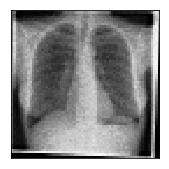

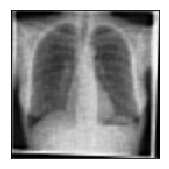

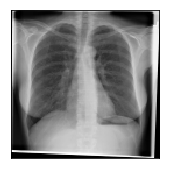

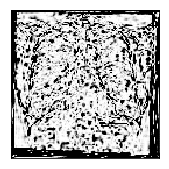

In [9]:
# Visualize Error
amount = 1
ind_ = ind[5] # [0.25, 0.1, 0.05, 0.01, 0.001, 0.0001]
# get predictions
indexes = np.random.choice(ind_, amount, replace=False)
print(indexes)
predictions = net.predict(np.take(train_x, indexes, axis = 0))
# get error
error = np.expand_dims(K.eval(loss(K.variable(np.take(train_y, \
            indexes, axis = 0)), K.variable(predictions))), axis=3)
# mean error * e4
print(np.squeeze(np.mean(error,(1,2)))*1e4)

# show heatmap of images with the most error
print('inputs > outputs > target > error')
plotrow(train_x, indexes)
plotrow(predictions, list(range(len(indexes))))
plotrow(train_y, indexes)
plotrow(error, list(range(len(indexes))), 0, 0.001)

In [6]:
def plotrow(img_array, indexes, vmin = 0, vmax = 1):
    amount_ = len(indexes)
    plt.figure(figsize=(3*amount_, 6))
    for n,i in enumerate(indexes):
        ax = plt.subplot(2, amount_, n + 1)
        plt.imshow(np.squeeze(img_array[i],2), cmap = 'Greys', vmin = vmin, vmax = vmax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [3]:
# Load Mean Errors
with open('mean_error.pkl', 'rb') as input:
	mean_errors = pickle.load(input)

In [6]:
real_images = {}
for idx, error in enumerate(mean_errors):
    idx = idx + 4000
    error = round(error,10)
    if error not in real_images:
        real_images[error] = [idx]
    else:
        real_images[error].append(idx)

In [17]:
repeats = {}
for key, value in real_images.items():
    num = len(value)
    if num not in repeats:
        repeats[num] = 1
    else:
        repeats[num] += 1
print(repeats)

{1: 8370, 2: 2607, 3: 613, 4: 98, 5: 31, 6: 5}


In [18]:
for key, value in real_images.items():
    if len(value) == 6:
        print(value)

[5132, 8740, 9955, 14000, 15514, 16764]
[4246, 6272, 6707, 12247, 13959, 14521]
[4219, 9960, 15064, 18076, 18561, 19588]
[7173, 7969, 11636, 13122, 13712, 18684]
[5668, 6331, 6421, 10609, 14427, 18485]
